In [2]:
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import sys, os
sys.path.append("C:/Users/lheindrich/Documents/Scalable-discovery/metacontroller/")
os.chdir("C:/Users/lheindrich/Documents/Scalable-discovery/metacontroller/")

from utils.distributions import Categorical

In [3]:
path = "C:/Users/lheindrich/Desktop/metacontroller/SSD_big_analysis/dataclips_asijmzuiradcsdorheehafetfkkv.json"

data = json.load(open(path))

In [4]:
def get_expected_score(trialdata, COST=1):
    path = trialdata["path"]
    queries = trialdata["queries"]["click"]["state"]["target"]
    # Replace first element with 0 for root
    ground_truth =  [0] + trialdata["stateRewards"][1:]
    reward = 0
    for node in path:
        if node in queries:
            reward += ground_truth[int(node)]
        else:
            reward += 0 # Depends on experiment, in this case the expectation of all nodes is 0
    # Click cost
    reward -= len(queries) * COST
    return reward

In [16]:
df_index = ["Participant", "Condition", "TrialId", "Score", "ExpectedScore", "NumClicks", "TestEnv"]
df_data = []

bonus_data = {}
known_workers = []
good_responses = 0

# Parse raw mturk data into dataframe
for p_index, p_data in enumerate(data["values"]):
    # Filter out empty responses
    response_data = p_data[-1]
    if response_data != None:
        p_res_obj = json.loads(response_data)
        condition = p_res_obj["condition"]
        # Obscure worker ID for publication
        worker = p_index #p_res_obj["workerId"]
        if worker in known_workers:
            print("Duplicate worker", worker)
        else: 
            known_workers.append(worker)
        p_res = p_res_obj["data"]
        # Filter our incomplete trials
        # Get last instruction index
        # Test trials start after the last instruction
        # Index of that in the experiment is variable due to repeated instructions/quiz
        instruction_index = 0
        for i in range(len(p_res)):
            if p_res[i]["trialdata"]["trial_type"] == "instructions":
                instruction_index = i+1
        if len(p_res) > instruction_index + 15:
            good_responses += 1
            for i in range(instruction_index+1,instruction_index+16):
                trial = p_res[i]
                trialdata = trial["trialdata"]
                assert trialdata["trial_type"] == "mouselab-mdp"
                trialid = trialdata["trial_id"]
                queries = trialdata["queries"]["click"]["state"]["target"]
                path = trialdata["path"]
                score = trialdata["score"]
                trial_id = int(trialdata["trial_id"])
                expected_score = get_expected_score(trialdata)
                df_data.append([worker, condition, trialid, score, expected_score, len(queries), trial_id])
        try:
            bonus_data[worker] = p_res_obj["questiondata"]["final_bonus"]
        except:
            pass
            #print("Uncompleted but usable trial for worker", worker)

print("Good responses", good_responses)
df = pd.DataFrame(df_data, columns=df_index)

Good responses 168


In [17]:
# Exclude participants with 0 clicks
participants = pd.DataFrame(df[df["NumClicks"] == 0].groupby("Participant").count()["NumClicks"])
excluded = list(participants[participants["NumClicks"]>7].index)
print("Exlcuded participants", excluded)
print(len(excluded))

Exlcuded participants [37, 59, 92, 134, 205, 268, 271]
7


In [26]:
df_after_exclusion = df[~df["Participant"].isin(excluded)]
df_after_exclusion.to_csv("C:/Users/lheindrich/Desktop/metacontroller/SSD_big_analysis/main_excluded.csv")
len(df_after_exclusion)

2415

In [19]:
print("Total", len(df_after_exclusion["Participant"].unique()))
df_after_exclusion.groupby(["Condition", "Participant"]).count()["TrialId"].reset_index().groupby("Condition").count()

Total 161


,Participant,TrialId
Condition,,
0,41,41
1,39,39
2,40,40
3,41,41


### Basic statistics of the data (rest in R)

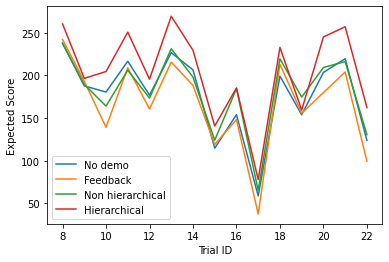

In [20]:
# Plot of scores per condition

score_per_trial = df_after_exclusion.groupby(["Condition", "TrialId"]).mean()[["Score", "ExpectedScore"]]
score_per_trial = score_per_trial.reset_index()


plt.plot("TrialId", "ExpectedScore", data=score_per_trial[score_per_trial["Condition"]==0], label="No demo")
plt.plot("TrialId", "ExpectedScore", data=score_per_trial[score_per_trial["Condition"]==1], label="Feedback")
plt.plot("TrialId", "ExpectedScore", data=score_per_trial[score_per_trial["Condition"]==2], label="Non hierarchical")
plt.plot("TrialId", "ExpectedScore", data=score_per_trial[score_per_trial["Condition"]==3], label="Hierarchical")
plt.xlabel("Trial ID")
plt.ylabel("Expected Score")
plt.legend()

In [21]:
df_after_exclusion.groupby("Condition").mean()["ExpectedScore"]

Condition
0    177.362602
1    167.022222
2    181.576667
3    204.479675
Name: ExpectedScore, dtype: float64

In [22]:
df_after_exclusion.groupby("Condition").std()["ExpectedScore"]

Condition
0     95.042320
1    103.420679
2     93.631203
3     83.156885
Name: ExpectedScore, dtype: float64